## Загрузка датасета с Kaggle

In [ ]:
!pip install kagglehub

In [ ]:
import kagglehub

path = kagglehub.dataset_download("cihan063/autism-image-data")

print("Path to dataset files:", path)

100%|██████████| 229M/229M [00:04<00:00, 52.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/cihan063/autism-image-data/versions/1


## Необходимые библиотеки

In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F

import random

from torch.utils.data import DataLoader
import os

## Предобработка данных

In [ ]:
# пути к данным
data_dir = "../kaggle/input/autism-image-data/AutismDataset"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")
valid_dir = os.path.join(data_dir, "valid")

# подкаталоги для классов валидационного набора
valid_dir_aut = os.path.join(valid_dir, "Autistic")
valid_dir_nonaut = os.path.join(valid_dir, "Non_Autistic")

# список файлов
train_filenames = os.listdir(train_dir)
test_filenames = os.listdir(test_dir)
# добавляем Autistic и Non_Autistic, т.к. названия файлов в формате '01.jpg' (слэш, чтобы потом не возникло проблем с путями)
valid_aut_filenames = ['Autistic/' + f for f in os.listdir(valid_dir_aut)]
valid_nonaut_filenames = ['Non_Autistic/' + f for f in os.listdir(valid_dir_nonaut)]


print(len(train_filenames), "train samples:", train_filenames)
print(len(test_filenames), "test samples:", test_filenames)
print(len(valid_aut_filenames), "autistic validation samples:", valid_aut_filenames)
print(len(valid_nonaut_filenames), "non-autistic validation samples:", valid_nonaut_filenames)

2540 train samples: ['Non_Autistic.609.jpg', 'Autistic.1124.jpg', 'Non_Autistic.979.jpg', 'Autistic.886.jpg', 'Non_Autistic.469.jpg', 'Autistic.1179.jpg', 'Autistic.1232.jpg', 'Non_Autistic.111.jpg', 'Autistic.993.jpg', 'Non_Autistic.222.jpg', 'Autistic.333.jpg', 'Non_Autistic.182.jpg', 'Non_Autistic.563.jpg', 'Autistic.710.jpg', 'Autistic.646.jpg', 'Autistic.840.jpg', 'Autistic.110.jpg', 'Non_Autistic.826.jpg', 'Non_Autistic.1244.jpg', 'Non_Autistic.1219.jpg', 'Autistic.1120.jpg', 'Non_Autistic.156.jpg', 'Autistic.929.jpg', 'Non_Autistic.1248.jpg', 'Autistic.952.jpg', 'Autistic.352.jpg', 'Non_Autistic.728.jpg', 'Non_Autistic.571.jpg', 'Non_Autistic.319.jpg', 'Autistic.44.jpg', 'Non_Autistic.508.jpg', 'Non_Autistic.531.jpg', 'Non_Autistic.703.jpg', 'Autistic.412.jpg', 'Autistic.797.jpg', 'Autistic.291.jpg', 'Non_Autistic.1018.jpg', 'Non_Autistic.572.jpg', 'Non_Autistic.867.jpg', 'Non_Autistic.1156.jpg', 'Autistic.366.jpg', 'Non_Autistic.259.jpg', 'Non_Autistic.365.jpg', 'Autistic.591.j

Объединяем данные для валидационного датасета и перемешиваем:

In [ ]:
valid_filenames = valid_aut_filenames + valid_nonaut_filenames
random.shuffle(valid_filenames)
print(len(valid_filenames), "total validation samples:", valid_filenames)

100 total validation samples: ['Autistic/09.jpg', 'Autistic/28.jpg', 'Non_Autistic/38.jpg', 'Non_Autistic/18.jpg', 'Autistic/13.jpg', 'Non_Autistic/39.jpg', 'Non_Autistic/26.jpg', 'Autistic/39.jpg', 'Non_Autistic/19.jpg', 'Autistic/03.jpg', 'Non_Autistic/06.jpg', 'Non_Autistic/40.jpg', 'Non_Autistic/47.jpg', 'Autistic/32.jpg', 'Autistic/05.jpg', 'Non_Autistic/31.jpg', 'Autistic/24.jpg', 'Autistic/45.jpg', 'Autistic/40.jpg', 'Autistic/25.jpg', 'Autistic/21.jpg', 'Autistic/36.jpg', 'Autistic/34.jpg', 'Non_Autistic/30.jpg', 'Non_Autistic/24.jpg', 'Autistic/02.jpg', 'Non_Autistic/32.jpg', 'Autistic/16.jpg', 'Non_Autistic/16.jpg', 'Non_Autistic/17.jpg', 'Autistic/17.jpg', 'Autistic/11.jpg', 'Autistic/33.jpg', 'Non_Autistic/50.jpg', 'Autistic/49.jpg', 'Non_Autistic/21.jpg', 'Non_Autistic/20.jpg', 'Non_Autistic/43.jpg', 'Autistic/07.jpg', 'Non_Autistic/41.jpg', 'Autistic/43.jpg', 'Autistic/23.jpg', 'Autistic/18.jpg', 'Autistic/38.jpg', 'Non_Autistic/37.jpg', 'Non_Autistic/25.jpg', 'Autistic/3

Визуализация случайного изображения:

In [ ]:
from PIL import Image

Original image size: (267, 284)


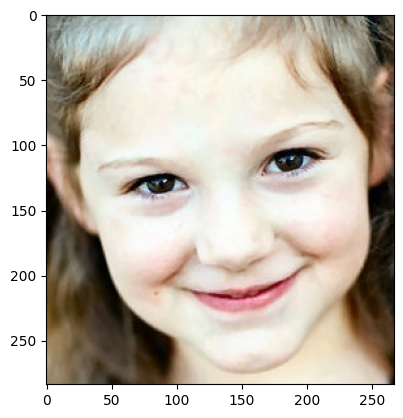

In [ ]:
sample_img = Image.open(train_dir+"/"+random.choice(train_filenames))
# или можно так:
# sample_img_path = os.path.join(train_dir, random.choice(train_filenames))
# sample_img = Image.open(sample_img_path)

print(f"Original image size: {sample_img.size}")  # (width, height) - исходный размер рандомного изображения
plt.imshow(sample_img)

In [ ]:
from torchvision import transforms

# трансформация (ресайз + преобразование в тензор)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # меняем размер на 224x224
    transforms.ToTensor(), # преобразуем в тензор [C, H, W]
    transforms.Normalize((0.5), (0.5))
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # статистика ImageNet, в целом тоже можно применять, особенно для предобученных моделей (resnet)
])


In [ ]:
def load_and_transform_images(filenames, directory):
    """Загрузка и преобразование изображений с назначением меток классов"""
    images = []
    labels = []
    for filename in filenames:
        img_path = os.path.join(directory, filename)
        img = Image.open(img_path).convert('RGB')  # открываем и конвертируем в RGB
        img = transform(img)
        label = 1 if filename.split('.')[0] == 'Autistic' or filename.split('/')[0] == 'Autistic' else 0 # метка (1 = Autistic, 0 = Non_Autistic)
        #label = 1 if filename.startswith('Autistic') else 0  # другой способ
        images.append(img)
        labels.append(label)
    return torch.stack(images), torch.tensor(labels)  # объединяем в тензоры


In [ ]:
# загрузка и преобразование данных
X_train, y_train = load_and_transform_images(train_filenames, train_dir)
X_valid, y_valid = load_and_transform_images(valid_filenames, valid_dir)
X_test, y_test = load_and_transform_images(test_filenames, test_dir)

# упаковываем их в датасеты
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
valid_dataset = torch.utils.data.TensorDataset(X_valid, y_valid)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=30, shuffle=True) # тренировочные данные перемешиваем каждую эпоху
valid_dataloader = DataLoader(valid_dataset, batch_size=30, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=30, shuffle=False)

# проверяем размерности тренировочного, валидационного и тестового наборов
print(f"Training set size: {X_train.shape}")  # [кол-во изображений, каналы=С, высота=H, ширина=W]
print(f"Validation set size: {X_valid.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: torch.Size([2540, 3, 224, 224])
Validation set size: torch.Size([100, 3, 224, 224])
Test set size: torch.Size([300, 3, 224, 224])


In [ ]:
# проверим баланс классов
print("Classes in train:", torch.bincount(y_train))
print("Classes in valid:", torch.bincount(y_valid))

Classes in train: tensor([1270, 1270])
Classes in valid: tensor([50, 50])


In [ ]:
# train_dataset[:7]

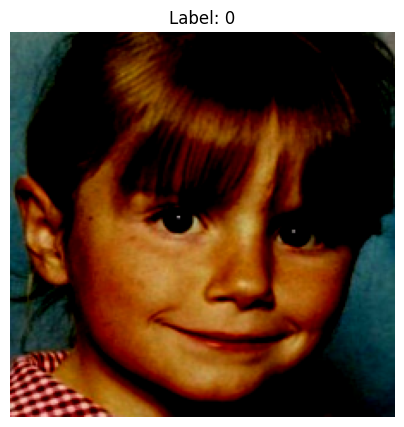

In [ ]:
# визуализируем пример после ресайза
plt.figure(figsize=(5, 5))
plt.imshow(X_train[0].permute(1, 2, 0))  # переводим из [C, H, W] в [H, W, C] для отображения (imshow ожидает изображение в формате [H, W, C] или [H, W] для ч/б)
plt.title(f"Label: {y_train[0]}")
plt.axis('off')
plt.show()


In [ ]:
sample, _ = train_dataset[0]
sample.shape

torch.Size([3, 224, 224])

## Несколько моделей

In [ ]:
activation = nn.ELU() # допускает отрицательные значения в отличие от ReLU

model1 = nn.Sequential(
    # изначально размерность 3 * 224 * 224
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1), # [32, 224, 224]
    activation, # добавляем нелинейность
    nn.MaxPool2d(2), # [32, 112, 112]

    nn.Conv2d(32, 64, kernel_size=3, padding=1), # [64, 112, 112]
    activation,
    nn.MaxPool2d(2), # [64, 56, 56]

    nn.Conv2d(64, 128, kernel_size=3, padding=1), # [128, 56, 56]
    activation,
    nn.MaxPool2d(2), # [128, 28, 28]

    nn.Conv2d(128, 256, kernel_size=3, padding=1), # [256, 28, 28]
    activation,
    nn.MaxPool2d(2), # [256, 14, 14]

    # разворачиваем в вектор (преобразование 4D-тензора [batch, С, H, W] в 2D [batch, features])
    nn.Flatten(), # [batch, 256 * 14 * 14]

    # полносвязный слой
    nn.Linear(256 * 14 * 14, 512),
    activation,
    nn.Dropout(0.3), # регуляризация - случайное отключение 30% нейронов во время обучения

    nn.Linear(512, 2)  # здесь нет активации - CrossEntropyLoss включает softmax    ([batch, 2])
)

Предобученные модели:

In [ ]:
from torchvision import models

model2 = models.resnet18(pretrained=True)
model2.fc = nn.Linear(512, 2)  # замена последнего слоя

In [ ]:
model3 = models.densenet121(pretrained=True)
model3.classifier = nn.Linear(1024, 2)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model4 = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    activation,
    nn.Dropout2d(0.1),
    nn.MaxPool2d(2),

    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    activation,
    nn.Dropout2d(0.1),
    nn.MaxPool2d(2),

    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    activation,
    nn.MaxPool2d(2),

    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.BatchNorm2d(256),
    activation,
    nn.MaxPool2d(2),

    nn.Flatten(),
    nn.Linear(256*14*14, 512),
    nn.BatchNorm1d(512),
    activation,
    nn.Dropout(0.3),

    nn.Linear(512, 2)
)

## Обучение моделей

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
criterion = nn.CrossEntropyLoss()

loaders = {"train": train_dataloader, "valid": valid_dataloader}

Визуализация:

In [ ]:
def plots(accuracy):
    """Функция для визуализации процесса обучения"""
    plt.figure(figsize=(12, 5))

    # график точности
    plt.plot(accuracy['train'], label='Train Accuracy')
    plt.plot(accuracy['valid'], label='Valid Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

In [ ]:
def evaluate_test_set(model, test_dataloader):
    """Оценка модели на тестовой выборке"""
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total

    return accuracy

In [ ]:
import matplotlib.pyplot as plt
from copy import deepcopy
import time

def train_model(model, patience=3):  # patience - сколько эпох терпеть ухудшение
    """Функция обучения модели с ранней остановкой"""
    start_time = time.time()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    model = model.to(device)
    max_epochs = 10
    accuracy = {"train": [], "valid": []}

    best_val_accuracy = 0.0
    best_epoch = 0
    best_model_weights = deepcopy(model.state_dict())  # сохраняем лучшие веса
    epochs_no_improve = 0  # счётчик эпох без улучшения

    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0

            for x_batch, y_batch in dataloader:
                x_batch = x_batch.to(device) # переносим данные на то же устройство
                y_batch = y_batch.to(device)

                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)
                    loss = criterion(outp, y_batch)

                preds = outp.argmax(-1) # номер класса с наибольшей вероятностью
                correct = (preds == y_batch).sum()  # количество правильных ответов
                all = y_batch.size(0) # общее количество примеров в батче
                epoch_correct += correct.item()
                epoch_all += all

            epoch_accuracy = epoch_correct / epoch_all

            accuracy[k].append(epoch_accuracy)

            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_accuracy:.4f}")

            if k == 'valid':
                # проверяем, улучшилась ли точность на валидации
                if epoch_accuracy > best_val_accuracy:
                    best_val_accuracy = epoch_accuracy
                    best_epoch = epoch
                    best_model_weights = deepcopy(model.state_dict())
                    epochs_no_improve = 0  # сбрасываем счётчик
                else:
                    epochs_no_improve += 1

                # проверяем условие ранней остановки
                if epochs_no_improve >= patience:
                    print(f'\nEarly stopping triggered after epoch {epoch+1}')
                    print(f'Best validation accuracy: {best_val_accuracy:.4f} at epoch {best_epoch+1}')

                    total_time = time.time() - start_time
                    # восстанавливаем лучшие веса модели
                    model.load_state_dict(best_model_weights)

                    # точность на тестовой выборке
                    test_accuracy = evaluate_test_set(model, test_dataloader)

                    # строим графики
                    plots(accuracy)
                    return {
                      'model': model,
                      'best_weights': best_model_weights,
                      'accuracy': accuracy,
                      'total_time': total_time,
                      'test_accuracy': test_accuracy
                  }

    # если дошли до конца эпох
    print(f'\nTraining completed. Best validation accuracy: {best_val_accuracy:.4f} at epoch {best_epoch+1}')
    total_time = time.time() - start_time
    model.load_state_dict(best_model_weights)

    test_accuracy = evaluate_test_set(model, test_dataloader)

    plots(accuracy)
    return {
      'model': model,
      'best_weights': best_model_weights,
      'accuracy': accuracy,
      'total_time': total_time,
      'test_accuracy': test_accuracy
    }


Epoch: 1
Loader: train. Accuracy: 0.6161
Loader: valid. Accuracy: 0.6900
Epoch: 2
Loader: train. Accuracy: 0.7150
Loader: valid. Accuracy: 0.6300
Epoch: 3
Loader: train. Accuracy: 0.7252
Loader: valid. Accuracy: 0.7800
Epoch: 4
Loader: train. Accuracy: 0.7744
Loader: valid. Accuracy: 0.6100
Epoch: 5
Loader: train. Accuracy: 0.7559
Loader: valid. Accuracy: 0.7800
Epoch: 6
Loader: train. Accuracy: 0.7882
Loader: valid. Accuracy: 0.7600

Early stopping triggered after epoch 6
Best validation accuracy: 0.7800 at epoch 3


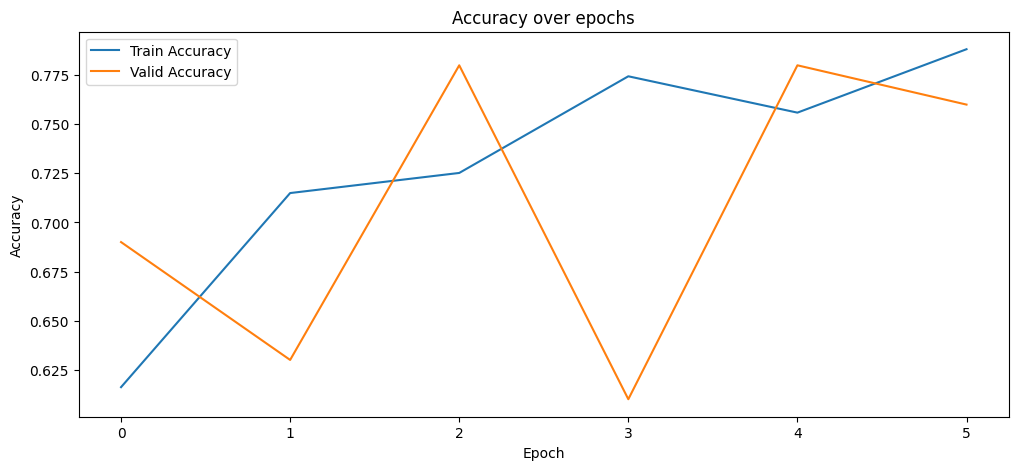

In [ ]:
results1 = train_model(model1)

In [ ]:
print(f"Model1 trained in {results1['total_time']:.2f} seconds")
print(f"Test Accuracy: {results1['test_accuracy']:.4f}")

Model1 trained in 33.24 seconds
Test Accuracy: 0.7767


Epoch: 1
Loader: train. Accuracy: 0.7354
Loader: valid. Accuracy: 0.6200
Epoch: 2
Loader: train. Accuracy: 0.7965
Loader: valid. Accuracy: 0.6100
Epoch: 3
Loader: train. Accuracy: 0.8390
Loader: valid. Accuracy: 0.7200
Epoch: 4
Loader: train. Accuracy: 0.8780
Loader: valid. Accuracy: 0.7600
Epoch: 5
Loader: train. Accuracy: 0.8953
Loader: valid. Accuracy: 0.7900
Epoch: 6
Loader: train. Accuracy: 0.9130
Loader: valid. Accuracy: 0.7700
Epoch: 7
Loader: train. Accuracy: 0.9319
Loader: valid. Accuracy: 0.7200
Epoch: 8
Loader: train. Accuracy: 0.9441
Loader: valid. Accuracy: 0.7900

Early stopping triggered after epoch 8
Best validation accuracy: 0.7900 at epoch 5


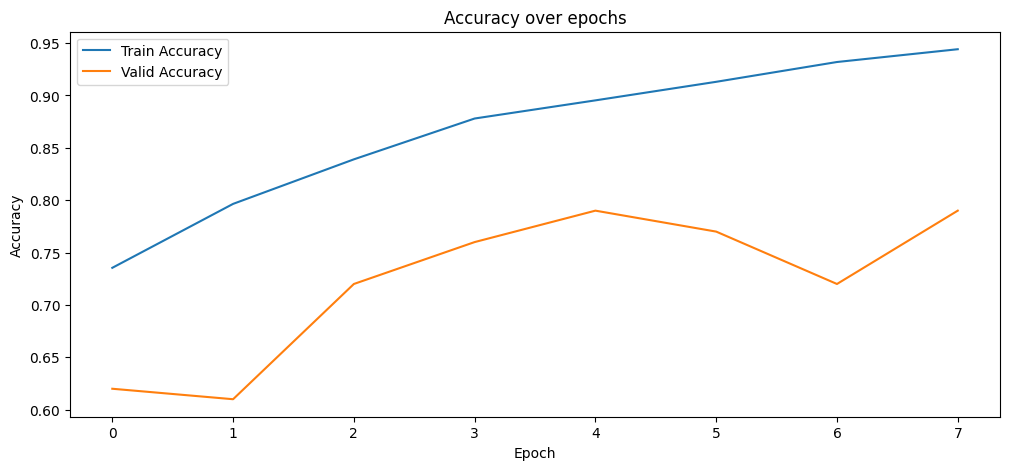

In [ ]:
results2 = train_model(model2)

In [ ]:
print(f"Model2 trained in {results2['total_time']:.2f} seconds")
print(f"Test Accuracy: {results2['test_accuracy']:.4f}")

Model2 trained in 63.01 seconds
Test Accuracy: 0.8300


Epoch: 1
Loader: train. Accuracy: 0.7520
Loader: valid. Accuracy: 0.6600
Epoch: 2
Loader: train. Accuracy: 0.8157
Loader: valid. Accuracy: 0.7900
Epoch: 3
Loader: train. Accuracy: 0.8335
Loader: valid. Accuracy: 0.8000
Epoch: 4
Loader: train. Accuracy: 0.8492
Loader: valid. Accuracy: 0.7700
Epoch: 5
Loader: train. Accuracy: 0.8677
Loader: valid. Accuracy: 0.7300
Epoch: 6
Loader: train. Accuracy: 0.8827
Loader: valid. Accuracy: 0.8300
Epoch: 7
Loader: train. Accuracy: 0.9028
Loader: valid. Accuracy: 0.7500
Epoch: 8
Loader: train. Accuracy: 0.9102
Loader: valid. Accuracy: 0.8100
Epoch: 9
Loader: train. Accuracy: 0.9075
Loader: valid. Accuracy: 0.7500

Early stopping triggered after epoch 9
Best validation accuracy: 0.8300 at epoch 6


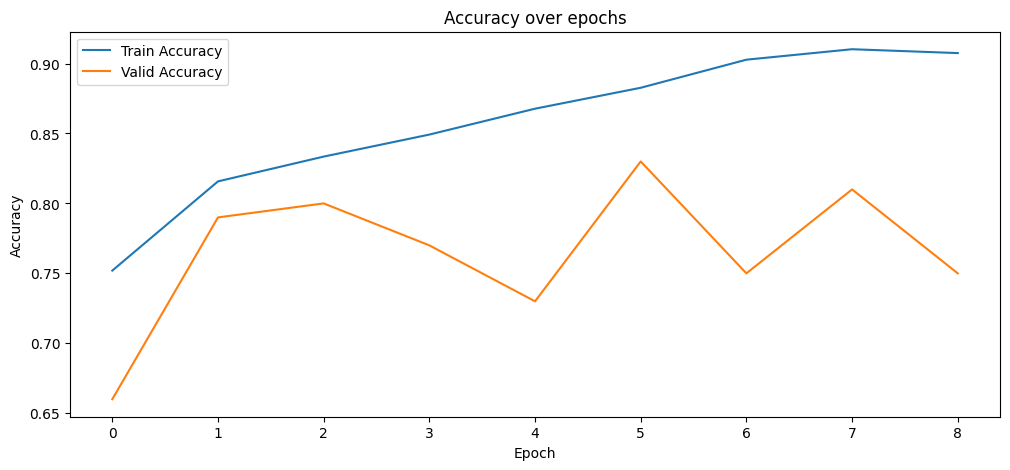

In [ ]:
results3 = train_model(model3)

Работает значительно медленнее первых двух:

In [ ]:
print(f"Model3 trained in {results3['total_time']:.2f} seconds")
print(f"Test Accuracy: {results3['test_accuracy']:.4f}")

Model3 trained in 232.11 seconds
Test Accuracy: 0.8367


Epoch: 1
Loader: train. Accuracy: 0.6949
Loader: valid. Accuracy: 0.6800
Epoch: 2
Loader: train. Accuracy: 0.7390
Loader: valid. Accuracy: 0.7200
Epoch: 3
Loader: train. Accuracy: 0.7677
Loader: valid. Accuracy: 0.7300
Epoch: 4
Loader: train. Accuracy: 0.7799
Loader: valid. Accuracy: 0.7500
Epoch: 5
Loader: train. Accuracy: 0.7941
Loader: valid. Accuracy: 0.7900
Epoch: 6
Loader: train. Accuracy: 0.8118
Loader: valid. Accuracy: 0.7500
Epoch: 7
Loader: train. Accuracy: 0.8165
Loader: valid. Accuracy: 0.7700
Epoch: 8
Loader: train. Accuracy: 0.8276
Loader: valid. Accuracy: 0.7500

Early stopping triggered after epoch 8
Best validation accuracy: 0.7900 at epoch 5


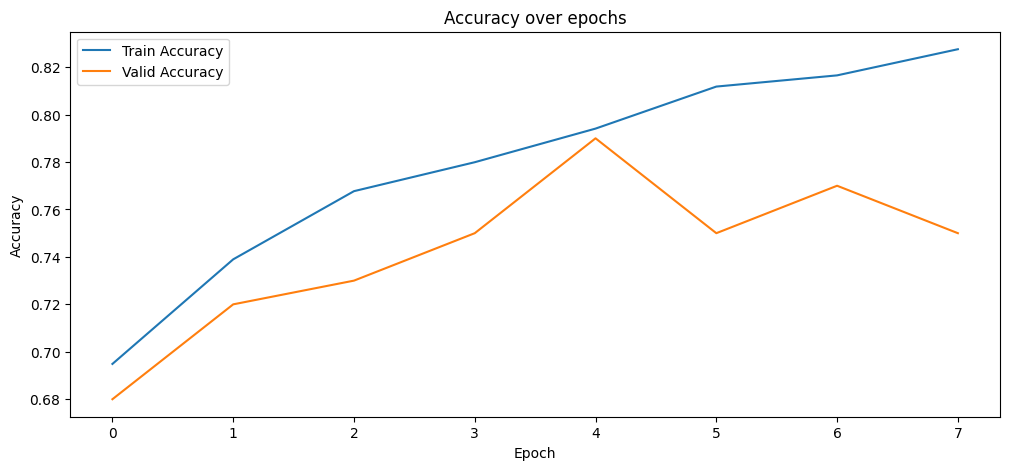

In [ ]:
results4 = train_model(model4)

In [ ]:
print(f"Model4 trained in {results4['total_time']:.2f} seconds")
print(f"Test Accuracy: {results4['test_accuracy']:.4f}")

Model4 trained in 57.67 seconds
Test Accuracy: 0.8133


## Визуализиация неправильно классифицированных изображений

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix_with_examples(model, test_dataset, test_dataloader, num_examples=7):
    """Визуализиация неправильно классифицированных изображений"""
    # num_samples - количество примеров для отображения (по умолчанию 7)

    model.eval()  # режим оценки
    all_preds = []
    all_labels = []
    class_names=['Non_Autistic', 'Autistic']

    with torch.no_grad():  # отключаем вычисление градиентов для ускорения
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # создаем confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # визуализация
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # находим индексы ошибочных примеров
    errors = np.where(np.array(all_labels) != np.array(all_preds))[0]

    # визуализируем примеры ошибок
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(errors[:num_examples]):
        img, true_label = test_dataset[idx]
        pred_label = all_preds[idx]

        plt.subplot(1, num_examples, i+1)
        plt.imshow(img.permute(1, 2, 0).cpu()) # преобразуем тензор [C,H,W] в [H,W,C] для отображения
        plt.title(f"True: {true_label}, Pred: {pred_label}")
        plt.axis('off')

    plt.show()

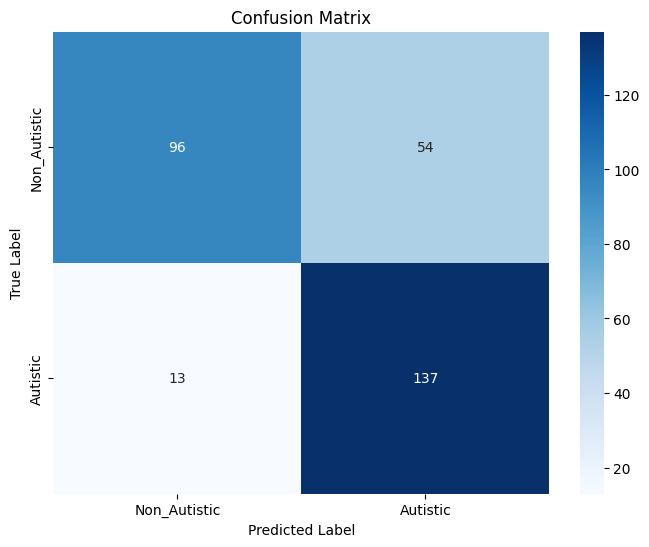

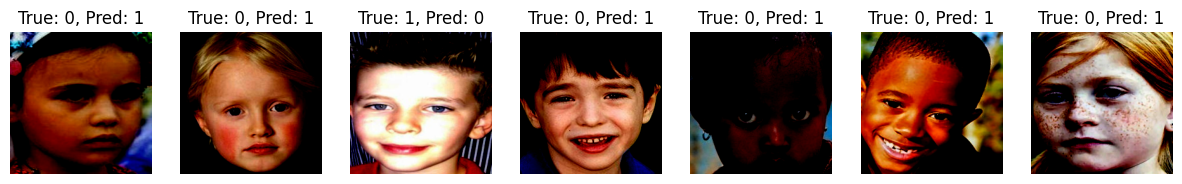

In [ ]:
plot_confusion_matrix_with_examples(model1, test_dataset, test_dataloader)

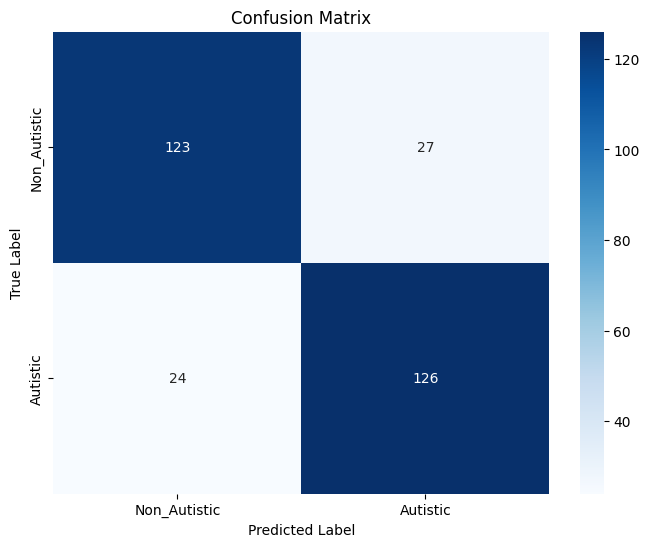

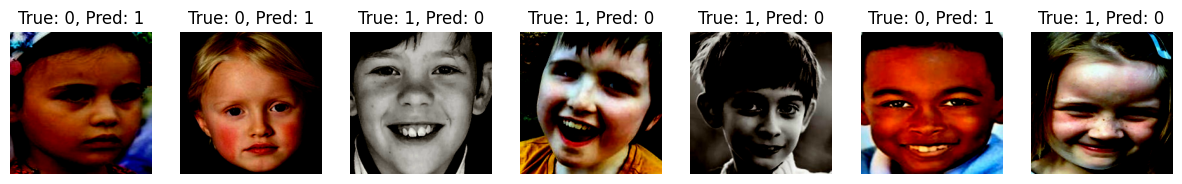

In [ ]:
plot_confusion_matrix_with_examples(model2, test_dataset, test_dataloader)

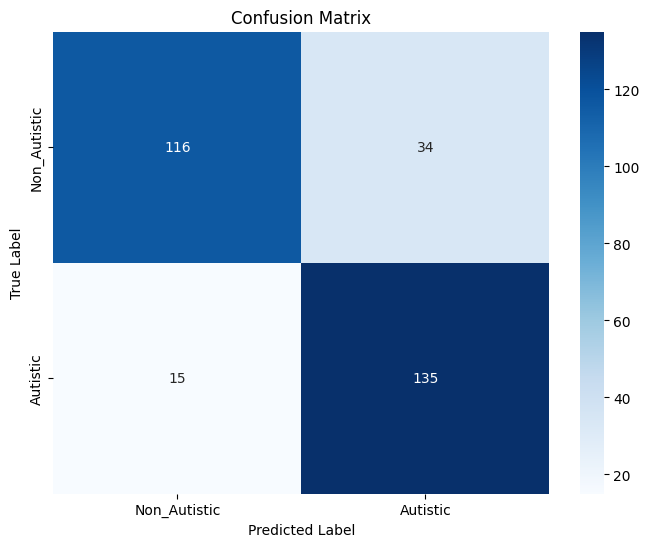

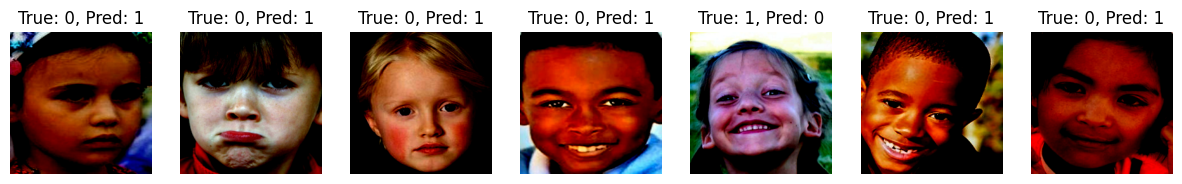

In [ ]:
plot_confusion_matrix_with_examples(model3, test_dataset, test_dataloader)

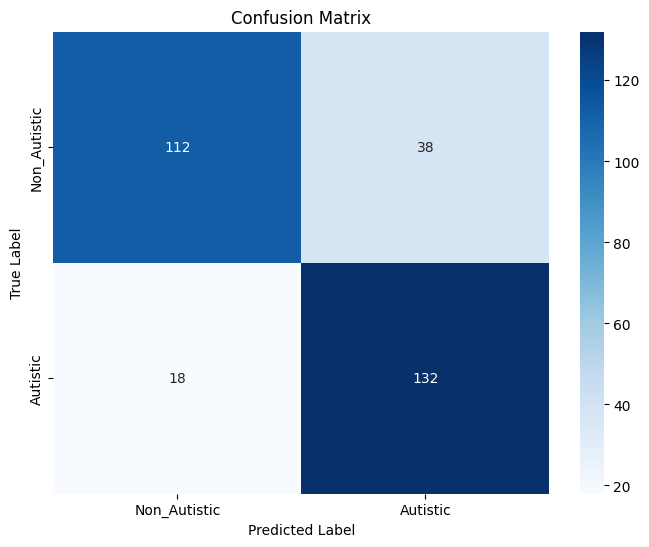

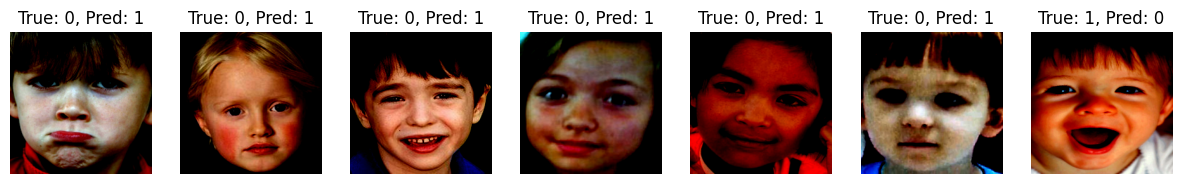

In [ ]:
plot_confusion_matrix_with_examples(model4, test_dataset, test_dataloader)